In [1]:
import numexpr as ne
import numpy as np
import tomocam
import tomopy
import dxchange as dx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import h5py
import os

In [2]:
def dXAtts(datafile, beamline='aps'):
    attrs = dict()
    fp = h5py.File(datafile, 'r')
    if beamline == 'als':
        gdata = dict(dx.reader._find_dataset_group(fp).attrs)
        attrs['pxsize']           = float(gdata['pxsize']) / 10  # /10 to convert units from mm to cm
        attrs['nslices']          = int(gdata['nslices'])
        attrs['nangles']          = int(gdata['nangles'])
        attrs['arange']           = float(gdata['arange'])
        attrs['nrays']            = int(gdata['nrays'])
        attrs['i0cycle']          = int(gdata['i0cycle'])
        attrs['num_dark_fields']  = int(gdata['num_dark_fields'])
        attrs['ind_dark']         = list(range(0, attrs['num_dark_fields']))
        attrs['num_bright_filed'] = int(gdata['num_bright_field'])
        attrs['rot_angle']        = float(gdata['rot_angle'])
    else:
        nangles, nslices, nrays = fp['exchange']['data'].shape
        attrs['nslices'] = nslices
        attrs['nangles'] = nangles
        attrs['nrays'] = nrays
    return attrs

# Input

In [3]:
filename = 'tomo_00026.h5'
inputPath = '/global/u2/d/dkumar/als/tomocam/data/tomo_00026/'
cor = 957
inputFile = os.path.join(inputPath, filename)
gdata = dXAtts(inputFile, beamline=None)
print(gdata)

{'nslices': 2048, 'nangles': 400, 'nrays': 2048}


# Output 

In [4]:
outputPath = '/global/u2/d/dkumar/als/tomocam/recon'
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
outputFile = os.path.join(outputPath, filename)

# Load data

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sinoUsed = (gdata['nslices']//2, gdata['nslices']//2 + 8, 1)
print(sinoUsed)
proj, flat, dark, theta = dx.read_aps_2bm(inputFile, sino=sinoUsed)
proj = proj.astype(np.float32)
theta = theta.astype(np.float32)

(1024, 1032, 1)


## Normalize and minus-log

In [6]:
proj = tomopy.normalize(proj, flat, dark, out=proj)
minimum_transmission = 0.01
mx = np.float32(minimum_transmission)
ne.evaluate('where(proj>mx, proj, mx)', out=proj)
proj = tomopy.minus_log(proj)

# Remove stripes

In [7]:
proj = tomopy.prep.stripe.remove_stripe_fw(proj, level = 7, sigma = 3)

In [8]:
sino = np.transpose(proj, [1, 0, 2]).astype(np.float32)

# Reconstruct object using MBIR

In [9]:
s = 0.025   
max_iters = 300
recon = tomocam.MBIR(sino, theta, center = cor, num_iters = max_iters, smoothness = s)

Iteration:   0 , Error:  1346.052734375
Iteration:   1 , Error:  743.4462280273438
Iteration:   2 , Error:  733.3890380859375
Iteration:   3 , Error:  720.7261962890625
Iteration:   4 , Error:  705.7303466796875
Iteration:   5 , Error:  688.3060913085938
Iteration:   6 , Error:  668.9025268554688
Iteration:   7 , Error:  647.4830322265625
Iteration:   8 , Error:  624.2984619140625
Iteration:   9 , Error:  599.5639038085938
Iteration:   10 , Error:  573.50244140625
Iteration:   11 , Error:  546.1578369140625
Iteration:   12 , Error:  517.899169921875
Iteration:   13 , Error:  488.8165283203125
Iteration:   14 , Error:  459.0697021484375
Iteration:   15 , Error:  429.148681640625
Iteration:   16 , Error:  398.81475830078125
Iteration:   17 , Error:  368.5791015625
Iteration:   18 , Error:  338.7127990722656
Iteration:   19 , Error:  309.10418701171875
Iteration:   20 , Error:  280.1716613769531
Iteration:   21 , Error:  252.00413513183594
Iteration:   22 , Error:  224.94143676757812
Iter

# Mask each reconstructed slice with a circle.

In [10]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

# Show results

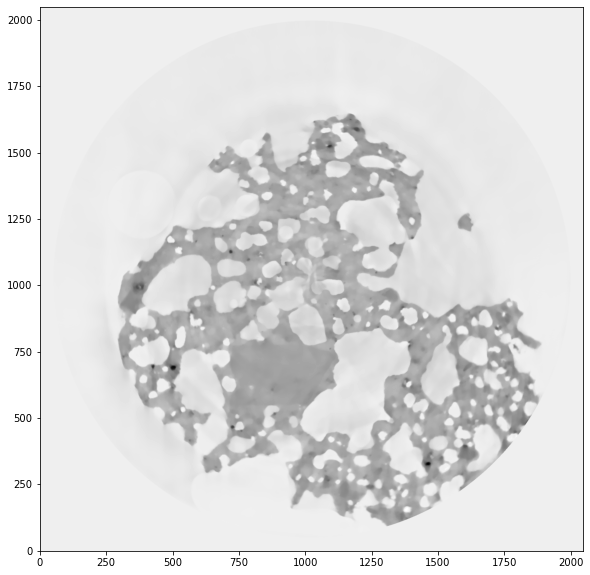

In [11]:
plt.imshow(recon[0], origin='lower', cmap='gray')

# Save to hdf5

In [12]:
with h5py.File(outputFile, 'w') as fp:
    dset = fp.create_dataset('recon', data = recon)
    dset.attrs['smoothness'] = s
    dset.attrs['num_iters'] = max_iters
    dset.attrs['remove_stripe_fw'] = 'level : 7, sigma: 3'
    dset.attrs['minimum_transmission'] = minimum_transmission